In [1]:
name = "Konstantin Baron von Drachenfels"

I've found this data set about airbnb accomodations on Kaggle (https://www.kaggle.com/stevezhenghp/airbnb-price-prediction). The data set is 2 years old. From the given information on Kaggle the data can be used to predict the prices of the accomodations looking at the provided information. This sounds interesting to me and thus I want to take a deeper look at the data and see if it qualifies for our homework. 

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import sys
sys.path.append("/Users/bolli/fastai/old/")

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

C:\Users\bolli\Anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\bolli\Anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
PATH = "data/airbnb/"

In [5]:
!ls {PATH}

train.csv


In [6]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False,
                    parse_dates=["first_review","last_review","host_since"])

In [7]:
df_raw.shape
#The data set consists out of 29 columns of information and 74.111 rows of data. That size qualifies perfectly for our hw.

(74111, 29)

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      74111 non-null  int64         
 1   log_price               74111 non-null  float64       
 2   property_type           74111 non-null  object        
 3   room_type               74111 non-null  object        
 4   amenities               74111 non-null  object        
 5   accommodates            74111 non-null  int64         
 6   bathrooms               73911 non-null  float64       
 7   bed_type                74111 non-null  object        
 8   cancellation_policy     74111 non-null  object        
 9   cleaning_fee            74111 non-null  bool          
 10  city                    74111 non-null  object        
 11  description             74111 non-null  object        
 12  first_review            58247 non-null  dateti

The provided columns as the room type, the city of the accomodation, information about reviews etc. seem to make sense and be purposeful to evaluate the price of the accomodation. The price is already displayed as the log of the price to ensure a comparability between the prices as percentage differences will be more interesting than absolute differences. We can assume that the price information is from the same time but we have no further information regarding this and no client to ask. Thus, this is an underlying assumption for the meaningfulness of our model. A lot of the columns seem to be booleans checking for certain attributes of the accomodation, host, etc. We have 3 time variables 'host_since','first_review' and 'last_review' 

In [9]:
df_raw.head(10)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaT,t,t,NaN,2015-04-19,f,NaT,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0
5,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,Real Bed,strict,True,SF,Beautiful private room overlooking scenic view...,2017-08-27,t,t,100%,2017-06-07,t,2017-09-05,37.753164,-122.429526,Comfort Suite San Francisco,Noe Valley,3,100.0,https://a0.muscache.com/im/pictures/82509143-4...,94131,1.0,1.0
6,11825529,4.418841,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",3,1.0,Real Bed,moderate,True,LA,Warm and cozy studio with full kitchen and bat...,2017-03-10,t,f,100%,2017-03-03,t,2017-04-21,33.980454,-118.462821,Beach Town Studio and Parking!!!11h,NaN,15,97.0,https://a0.muscache.com/im/pictures/4c920c60-4...,90292,1.0,1.0
7,13971273,4.787492,Condominium,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Wheelchair...",2,1.0,Real Bed,moderate,True,LA,Arguably the best location (and safest) in dow...,2016-12-16,t,t,100%,2013-05-18,f,2017-04-12,34.046737,-118.260439,"Near LA Live, Staple's. Starbucks inside. OWN ...",Downtown,9,93.0,https://a0.muscache.com/im/pictures/61bd05d5-c...,90015,1.0,1.0
8,180792,4.787492,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Pets live ...",2,1.0,Real Bed,moderate,True,SF,Garden Studio with private entrance from the s...,2016-02-13,t,f,100%,2015-06-04,f,2017-09-24,37.781128,-122.501095,Cozy Garden Studio - Private Entry,Richmond District,159,99.0,https://a0.muscache.com/im/pictures/0ed6c128-7...,94121,1.0,1.0
9,5385260,3.583519,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",2,1.0,Real Bed,moderate,True,LA,"Quiet community. Close to supermarkets,restaur...",2017-04-03,t,f,100%,2017-03-12,t,2017-04-16,33.992563,-117.895997,No.7 Queen Size Cozy Room 舒适大床房,NaN,2,90.0,https://a0.muscache.com/im/pictures/8d2f08ce-b...,91748,1.0,1.0


Each accomodation has an id so that it can be identified. We can also observe that the data is not structured in a temporal order looking at the columns of 'host_since', 'first_review' and 'last_review'.

One big issue with the data is, that we have the very meaningful features 'amneties','description' and 'name with strings of information in them which are useless for the random forest in the format in which they are presented. Especially for amneties we need to extract the indivdual features mentioned in text like "Wireless internet" or "air conditioning and turn them into individual boolean features. An analysis of the features 'description' and 'name' will be difficult as the impact of the description and the name on the willingness to buy of the potential costumer is important but qualitative and subjective and thus very hard to quantify and generalize.

In [10]:
df_raw.describe(include='all')

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
count,7.411100e+04,74111.000000,74111,74111,74111,74111.000000,73911.000000,74111,74111,74111,74111,74111,58247,73923,73923,55812,73923,74111,58284,74111.000000,74111.000000,74111,67239,74111.000000,57389.000000,65895,73145,74020.000000,73980.000000
unique,NaN,NaN,35,3,67122,NaN,NaN,5,5,2,6,73479,2554,2,2,80,3087,2,1371,NaN,NaN,73359,619,NaN,NaN,65883,769,NaN,NaN
top,NaN,NaN,Apartment,Entire home/apt,{},NaN,NaN,Real Bed,strict,True,NYC,"Hello, I've been running guest house for Korea...",2017-01-01 00:00:00,t,t,100%,2015-03-30 00:00:00,f,2017-04-30 00:00:00,NaN,NaN,Bunk bed in the Treat Street Clubhouse,Williamsburg,NaN,NaN,https://a0.muscache.com/im/pictures/70087089/b...,11211.0,NaN,NaN
freq,NaN,NaN,49003,41310,586,NaN,NaN,72028,32374,54403,32349,8,293,73697,49748,43254,246,54660,1344,NaN,NaN,8,2862,NaN,NaN,3,1368,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-11-17 00:00:00,NaN,NaN,NaN,2008-03-03 00:00:00,NaN,2009-01-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-05 00:00:00,NaN,NaN,NaN,2017-10-04 00:00:00,NaN,2017-10-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.126662e+07,4.782069,NaN,NaN,NaN,3.155146,1.235263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.445958,-92.397525,NaN,NaN,20.900568,94.067365,NaN,NaN,1.265793,1.710868
std,6.081735e+06,0.717394,NaN,NaN,NaN,2.153589,0.582044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080167,21.705322,NaN,NaN,37.828641,7.836556,NaN,NaN,0.852143,1.254142
min,3.440000e+02,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.338905,-122.511500,NaN,NaN,0.000000,20.000000,NaN,NaN,0.000000,0.000000
25%,6.261964e+06,4.317488,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.127908,-118.342374,NaN,NaN,1.000000,92.000000,NaN,NaN,1.000000,1.000000


We can see that the data includes hosts who started Airbnb in 2008 to people who started to be hosts on October 4th 2017 which is very soon before the end of this data collection since the last review in this dataset was made on October 5th 2017.

In [11]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [12]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw)) 

accommodates              0.000000
amenities                 0.000000
bathrooms                 0.002699
bed_type                  0.000000
bedrooms                  0.001228
beds                      0.001768
cancellation_policy       0.000000
city                      0.000000
cleaning_fee              0.000000
description               0.000000
first_review              0.214057
host_has_profile_pic      0.002537
host_identity_verified    0.002537
host_response_rate        0.246913
host_since                0.002537
id                        0.000000
instant_bookable          0.000000
last_review               0.213558
latitude                  0.000000
log_price                 0.000000
longitude                 0.000000
name                      0.000000
neighbourhood             0.092726
number_of_reviews         0.000000
property_type             0.000000
review_scores_rating      0.225635
room_type                 0.000000
thumbnail_url             0.110861
zipcode             

The integrity of the data looks pretty good. The only columns with larger amounts of missing data are the the ones concerning the ratings and the host response rate. Concerning the ratings that makes sense as not all accomdations will have ratings. Thus, the data looks very promising so far and appropriate for our homework. Thus, I will proceed with the initial processing and perform first analyses on the data.

# Initial Processing

The boolean variables are imported as object datatype with the string "t" for true and the string "f" for false except for the feature 'cleaning_fee'. So lets change them all into proper boolean datatypes. 

In [13]:
df_raw.cleaning_fee = df_raw.cleaning_fee.map({'False' : False, 'True' : True})
df_raw.cleaning_fee = df_raw.cleaning_fee.astype(bool)

df_raw.host_has_profile_pic = df_raw.host_has_profile_pic.map({'f' : False, 't' : True})
df_raw.host_has_profile_pic = df_raw.host_has_profile_pic.astype(bool)

df_raw.host_identity_verified = df_raw.host_identity_verified.map({'f' : False, 't' : True})
df_raw.host_identity_verified = df_raw.host_identity_verified.astype(bool)

df_raw.instant_bookable = df_raw.instant_bookable.map({'f' : False, 't' : True})
df_raw.instant_bookable = df_raw.instant_bookable.astype(bool)

Let's handle the column 'amenities'. At first we'll create a series 'new' which collects all the strings of information for each host in a list. We can observe that the different amenities of interest are not ordered in a way that they could be used straight away.

In [14]:
new = df_raw["amenities"].str.split(",")
#the parameter expand=True would directly create a new dataframe with one string per column.
#However the strings would not be ordered. Thus, looking at the series below the first column would e.g. include 
#"Wireless Internet" for row 0 and 1 but "TV" for row 2,3 and 4. Hence, a split into a series is better.

In [15]:
new

0        [{"Wireless Internet", "Air conditioning", Kit...
1        [{"Wireless Internet", "Air conditioning", Kit...
2        [{TV, "Cable TV", "Wireless Internet", "Air co...
3        [{TV, "Cable TV", Internet, "Wireless Internet...
4        [{TV, Internet, "Wireless Internet", "Air cond...
                               ...                        
74106                                                 [{}]
74107    [{TV, "Cable TV", Internet, "Wireless Internet...
74108    [{TV, Internet, "Wireless Internet", "Air cond...
74109    [{TV, "Wireless Internet", "Air conditioning",...
74110    [{TV, Internet, "Wireless Internet", Kitchen, ...
Name: amenities, Length: 74111, dtype: object

In [16]:
num_occurences = {}

for n in range(0,74111):
    for string in new[n]:
        string = string.strip('{}\'\"')       
        if string in num_occurences:
            num_occurences[string] += 1
        else:
            num_occurences[string] = 1

for key,val in num_occurences.items():
    occurence_rate = val/len(new)
    print(key, occurence_rate)

Wireless Internet 0.9615981433255522
Air conditioning 0.7449636356276397
Kitchen 0.9111467933235282
Heating 0.9050343403813199
Family/kid friendly 0.4996019484287083
Essentials 0.8636369769669819
Hair dryer 0.5846635452227065
Iron 0.5624940966927986
translation missing: en.hosting_amenity_50 0.34125838269622594
Washer 0.582491128172606
Dryer 0.5763112088623821
Smoke detector 0.8328992996991
Fire extinguisher 0.4145673381819163
Shampoo 0.6674447787777793
Hangers 0.6635047428856715
TV 0.707830146671884
Cable TV 0.32725236469619895
Breakfast 0.11207513054742212
Buzzer/wireless intercom 0.22983092928175305
Carbon monoxide detector 0.6367475813307066
Laptop friendly workspace 0.5896965362766661
Internet 0.602447679831604
Indoor fireplace 0.1254874445089123
First aid kit 0.3714968088407929
Elevator in building 0.08658633671114949
Pool 0.08477823804833291
Free parking on premises 0.31896749470389013
Gym 0.1010781125608884
Hot tub 0.08541242190767902
Wheelchair accessible 0.0654153904278717
Do

At first we loop through the different rows to check for all the different amenities that are mentioned by the hosts. We also look at the frequency in which they occur to assess their relevance as we have a very large number of amenities. We might not want to include them all as meaningless rows would steal valuable spots in splits in the trees of our RandomForestRegressor.
Thus, I decide to only include those with an occurence_rate >= 5% as one can observe below. Those, now included but with a little impact on the price can be dropped out at a later stage.

In [17]:
amenities_included = []

for key,val in num_occurences.items():
    occurence_rate = val/len(new)
    if occurence_rate >= 0.05:
        amenities_included.append(key)
        print(key, occurence_rate)

Wireless Internet 0.9615981433255522
Air conditioning 0.7449636356276397
Kitchen 0.9111467933235282
Heating 0.9050343403813199
Family/kid friendly 0.4996019484287083
Essentials 0.8636369769669819
Hair dryer 0.5846635452227065
Iron 0.5624940966927986
translation missing: en.hosting_amenity_50 0.34125838269622594
Washer 0.582491128172606
Dryer 0.5763112088623821
Smoke detector 0.8328992996991
Fire extinguisher 0.4145673381819163
Shampoo 0.6674447787777793
Hangers 0.6635047428856715
TV 0.707830146671884
Cable TV 0.32725236469619895
Breakfast 0.11207513054742212
Buzzer/wireless intercom 0.22983092928175305
Carbon monoxide detector 0.6367475813307066
Laptop friendly workspace 0.5896965362766661
Internet 0.602447679831604
Indoor fireplace 0.1254874445089123
First aid kit 0.3714968088407929
Elevator in building 0.08658633671114949
Pool 0.08477823804833291
Free parking on premises 0.31896749470389013
Gym 0.1010781125608884
Hot tub 0.08541242190767902
Wheelchair accessible 0.0654153904278717
Do

In [18]:
len(amenities_included)
#Thus, I willd include 52 out of the 131 amenities

52

In [19]:
amenities = []

for n in range(0,74111):
    for string in new[n]:
        string = string.strip('{}\'\"')
        if string in amenities:
            continue
        else: 
            amenities.append(string)

len(amenities)

131

In [20]:
amenities

['Wireless Internet',
 'Air conditioning',
 'Kitchen',
 'Heating',
 'Family/kid friendly',
 'Essentials',
 'Hair dryer',
 'Iron',
 'translation missing: en.hosting_amenity_50',
 'Washer',
 'Dryer',
 'Smoke detector',
 'Fire extinguisher',
 'Shampoo',
 'Hangers',
 'TV',
 'Cable TV',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Carbon monoxide detector',
 'Laptop friendly workspace',
 'Internet',
 'Indoor fireplace',
 'First aid kit',
 'Elevator in building',
 'Pool',
 'Free parking on premises',
 'Gym',
 'Hot tub',
 'Wheelchair accessible',
 'Doorman',
 'Dog(s)',
 'Cat(s)',
 'Other pet(s)',
 'Lock on bedroom door',
 'Pets live on this property',
 'Private entrance',
 'Hot water',
 'Bed linens',
 'Extra pillows and blankets',
 'Coffee maker',
 'Refrigerator',
 'Dishes and silverware',
 'Garden or backyard',
 'Pets allowed',
 'Safety card',
 '24-hour check-in',
 'Self Check-In',
 'Lockbox',
 'Suitable for events',
 'translation missing: en.hosting_amenity_49',
 'Elevator',
 'Microwave',
 

Filter via search through strings will be difficult and one has to be attentive as terms like 'hot', 'entrance' etc. are used multiple times. Thus I've created this overview as a little help going through the different amenities making sure that I don't include multiple amenities in a dictionary.

As one can observe below I will loop through the different rows checking if a certain keyword as "Internet" can be found in a list. If that is the case the number of the row will be saved with the boolean value True. If that is not the case the boolean value False will be saved with the number of the row. Below I search for "Internet" as I wanted to create one dictionary for the amenities "Internet" and "Wireless Internet" as one can assume that their value for the customer is the same and we want to avoid unnecesary correlation in the model.

In [21]:
Internet = {}

for n in range(0,74111):
    for string in new[n]:
        if "Internet" in string:
            Internet[n] = True
            break
        else:
            Internet[n] = False
            
sum(1 for condition in Internet.values() if condition)/len(Internet)
#~97% of the hosts offer an internet access to their guests

0.9663882554546559

In [22]:
Internet
#The dictionary looks promising. Checking for the rows 1 / 14 as a small sample (I've checked for more values),
#we can observe that they indeed include / don't include internet

{0: True,
 1: True,
 2: True,
 3: True,
 4: True,
 5: True,
 6: True,
 7: True,
 8: True,
 9: True,
 10: True,
 11: True,
 12: True,
 13: True,
 14: False,
 15: True,
 16: True,
 17: True,
 18: True,
 19: True,
 20: True,
 21: True,
 22: True,
 23: True,
 24: True,
 25: True,
 26: True,
 27: True,
 28: True,
 29: True,
 30: True,
 31: True,
 32: True,
 33: True,
 34: True,
 35: True,
 36: True,
 37: True,
 38: True,
 39: True,
 40: True,
 41: False,
 42: True,
 43: True,
 44: True,
 45: True,
 46: True,
 47: True,
 48: True,
 49: True,
 50: True,
 51: True,
 52: True,
 53: True,
 54: True,
 55: True,
 56: True,
 57: True,
 58: True,
 59: True,
 60: True,
 61: True,
 62: True,
 63: True,
 64: False,
 65: True,
 66: True,
 67: True,
 68: True,
 69: True,
 70: True,
 71: True,
 72: True,
 73: True,
 74: True,
 75: True,
 76: True,
 77: True,
 78: True,
 79: True,
 80: True,
 81: True,
 82: True,
 83: True,
 84: True,
 85: True,
 86: True,
 87: True,
 88: True,
 89: True,
 90: True,
 91: T

In [23]:
new[1]

['{"Wireless Internet"',
 '"Air conditioning"',
 'Kitchen',
 'Heating',
 '"Family/kid friendly"',
 'Washer',
 'Dryer',
 '"Smoke detector"',
 '"Fire extinguisher"',
 'Essentials',
 'Shampoo',
 'Hangers',
 '"Hair dryer"',
 'Iron',
 '"translation missing: en.hosting_amenity_50"}']

In [24]:
new[14]

['{Kitchen',
 'Heating',
 '"Smoke detector"',
 '"Carbon monoxide detector"',
 'Essentials',
 '"Hair dryer"',
 '"translation missing: en.hosting_amenity_50"}']

In [25]:
len(Internet)
#The dictionary also has the correct number of rows.

74111

Now we take the intermediate step to transform the dictionary into a dataframe as the direct addition of the dictionary to our dataframe df_raw via the pd.DataFrame.append function exceeds the capacity of my laptop memory.

In [26]:
df_internet = pd.DataFrame.from_dict(Internet, orient='index')

In [27]:
df_raw['has_internet'] = df_internet

In [28]:
df_raw.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,has_internet
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,True,True,NaN,2012-03-26,False,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,True
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,True,False,100%,2017-06-19,True,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,True
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,True,True,100%,2016-10-25,True,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,True
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaT,True,True,NaN,2015-04-19,False,NaT,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,True
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,True,True,100%,2015-03-01,True,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0,True


We can observe that the column 'has_internet' has been succesfully added to our dataframe. As we've now seen that this works, we can follow this process for the remaining 51 amenities that we want to include. Unfortunately, this used a lot of code and space as I've not managed to find a way to systemize the automatic renaming of the dictionaries after the different strings of amenities.

In [29]:
Air_conditioning = {}

for n in range(0,74111):
    for string in new[n]:
        if "Air conditioning" in string:
            Air_conditioning[n] = True
            break
        else:
            Air_conditioning[n] = False

df_Air_conditioning = pd.DataFrame.from_dict(Air_conditioning, orient='index')
df_raw['has_aircon'] = df_Air_conditioning

In [30]:
Kitchen = {}

for n in range(0,74111):
    for string in new[n]:
        if "Kitchen" in string:
            Kitchen[n] = True
            break
        else:
            Kitchen[n] = False
            
df_Kitchen = pd.DataFrame.from_dict(Kitchen, orient='index')
df_raw['has_kitchen'] = df_Kitchen

In [31]:
heating = {}

for n in range(0,74111):
    for string in new[n]:
        if "Heating" in string:
            heating[n] = True
            break
        else:
            heating[n] = False
            
df_heating = pd.DataFrame.from_dict(heating, orient='index')
df_raw['has_heating'] = df_heating

In [32]:
family_friendly = {}

for n in range(0,74111):
    for string in new[n]:
        if "Family" in string:
            family_friendly[n] = True
            break
        else:
            family_friendly[n] = False
            
df_family_friendly = pd.DataFrame.from_dict(family_friendly, orient='index')
df_raw['is_family_friendly'] = df_family_friendly

In [33]:
Essentials = {}

for n in range(0,74111):
    for string in new[n]:
        if "Essentials" in string:
            Essentials[n] = True
            break
        else:
            Essentials[n] = False
            
df_Essentials = pd.DataFrame.from_dict(Essentials, orient='index')
df_raw['has_Essentials'] = df_Essentials

In [34]:
Hair_dryer = {}

for n in range(0,74111):
    for string in new[n]:
        if "Hair dryer" in string:
            Hair_dryer[n] = True
            break
        else:
            Hair_dryer[n] = False
            
df_Hair_dryer = pd.DataFrame.from_dict(Hair_dryer, orient='index')
df_raw['has_hairdryer'] = df_Hair_dryer

In [35]:
Iron = {}

for n in range(0,74111):
    for string in new[n]:
        if "Iron" in string:
            Iron[n] = True
            break
        else:
            Iron[n] = False
            
df_Iron = pd.DataFrame.from_dict(Iron, orient='index')
df_raw['has_Iron'] = df_Iron

In [36]:
translation_missing = {}

for n in range(0,74111):
    for string in new[n]:
        if "translation missing" in string:
            translation_missing[n] = True
            break
        else:
            translation_missing[n] = False
            
df_translation_missing = pd.DataFrame.from_dict(translation_missing, orient='index')
df_raw['translation_missing'] = df_translation_missing

In [37]:
Washer = {}

for n in range(0,74111):
    for string in new[n]:
        if "Washer" in string:
            Washer[n] = True
            break
        else:
            Washer[n] = False

df_Washer = pd.DataFrame.from_dict(Washer, orient='index')
df_raw['has_Washer'] = df_Washer

In [38]:
Dryer = {}

for n in range(0,74111):
    for string in new[n]:
        if "Dryer" in string:
            Dryer[n] = True
            break
        else:
            Dryer[n] = False

df_Dryer = pd.DataFrame.from_dict(Dryer, orient='index')
df_raw['has_Dryer'] = df_Dryer

In [39]:
Smoke_CO_detector = {}

for n in range(0,74111):
    for string in new[n]:
        if "detector" in string:
            Smoke_CO_detector[n] = True
            break
        else:
            Smoke_CO_detector[n] = False

df_Smoke_CO_detector = pd.DataFrame.from_dict(Smoke_CO_detector, orient='index')
df_raw['has_Smoke/CO_detector'] = df_Smoke_CO_detector

In [40]:
Fire_extinguisher = {}

for n in range(0,74111):
    for string in new[n]:
        if "extinguisher" in string:
            Fire_extinguisher[n] = True
            break
        else:
            Fire_extinguisher[n] = False

df_Fire_extinguisher = pd.DataFrame.from_dict(Fire_extinguisher, orient='index')
df_raw['has_Fire_extinguisher'] = df_Fire_extinguisher

In [41]:
Shampoo = {}

for n in range(0,74111):
    for string in new[n]:
        if "Shampoo" in string:
            Shampoo[n] = True
            break
        else:
            Shampoo[n] = False

df_Shampoo = pd.DataFrame.from_dict(Shampoo, orient='index')
df_raw['has_Shampoo'] = df_Shampoo

In [42]:
Hangers = {}

for n in range(0,74111):
    for string in new[n]:
        if "Hangers" in string:
            Hangers[n] = True
            break
        else:
            Hangers[n] = False

df_Hangers = pd.DataFrame.from_dict(Hangers, orient='index')
df_raw['has_Hangers'] = df_Hangers

In [43]:
TV = {}

for n in range(0,74111):
    for string in new[n]:
        if "TV" in string:
            TV[n] = True
            break
        else:
            TV[n] = False

df_TV = pd.DataFrame.from_dict(TV, orient='index')
df_raw['has_TV'] = df_TV

In [44]:
Breakfast = {}

for n in range(0,74111):
    for string in new[n]:
        if "Breakfast" in string:
            Breakfast[n] = True
            break
        else:
            Breakfast[n] = False

df_Breakfast = pd.DataFrame.from_dict(Breakfast, orient='index')
df_raw['Breakfast_included'] = df_Breakfast

In [45]:
Buzzer_wireless_intercom = {}

for n in range(0,74111):
    for string in new[n]:
        if "Buzzer" in string:
            Buzzer_wireless_intercom[n] = True
            break
        else:
            Buzzer_wireless_intercom[n] = False

df_Buzzer_wireless_intercom = pd.DataFrame.from_dict(Buzzer_wireless_intercom, orient='index')
df_raw['has_electric_doorbell'] = df_Buzzer_wireless_intercom

In [46]:
Laptop_friendly_workspace = {}

for n in range(0,74111):
    for string in new[n]:
        if "Laptop" in string:
            Laptop_friendly_workspace[n] = True
            break
        else:
            Laptop_friendly_workspace[n] = False

df_Laptop_friendly_workspace = pd.DataFrame.from_dict(Laptop_friendly_workspace, orient='index')
df_raw['Laptop_friendly_workspace'] = df_Laptop_friendly_workspace

In [47]:
Indoor_fireplace = {}

for n in range(0,74111):
    for string in new[n]:
        if "fireplace" in string:
            Indoor_fireplace[n] = True
            break
        else:
            Indoor_fireplace[n] = False

df_Indoor_fireplace = pd.DataFrame.from_dict(Indoor_fireplace, orient='index')
df_raw['has_Indoor_fireplace'] = df_Indoor_fireplace

In [48]:
First_aid_kit = {}

for n in range(0,74111):
    for string in new[n]:
        if "aid" in string:
            First_aid_kit[n] = True
            break
        else:
            First_aid_kit[n] = False

df_First_aid_kit = pd.DataFrame.from_dict(First_aid_kit, orient='index')
df_raw['has_First_aid_kit'] = df_First_aid_kit

In [49]:
Elevator = {}

for n in range(0,74111):
    for string in new[n]:
        if "Elevator" in string:
            Elevator[n] = True
            break
        else:
            Elevator[n] = False

df_Elevator = pd.DataFrame.from_dict(Elevator, orient='index')
df_raw['has_Elevator'] = df_Elevator

In [50]:
Pool = {}

for n in range(0,74111):
    for string in new[n]:
        if "Pool" in string:
            Pool[n] = True
            break
        else:
            Pool[n] = False

df_Pool = pd.DataFrame.from_dict(Pool, orient='index')
df_raw['has_Pool'] = df_Pool

In [51]:
Free_parking = {}

for n in range(0,74111):
    for string in new[n]:
        if "parking" in string:
            Free_parking[n] = True
            break
        else:
            Free_parking[n] = False

df_Free_parking = pd.DataFrame.from_dict(Free_parking, orient='index')
df_raw['Free_parking'] = df_Free_parking

In [52]:
Gym = {}

for n in range(0,74111):
    for string in new[n]:
        if "Gym" in string:
            Gym[n] = True
            break
        else:
            Gym[n] = False

df_Gym = pd.DataFrame.from_dict(Gym, orient='index')
df_raw['has_Gym'] = df_Gym

In [53]:
Hot_tub = {}

for n in range(0,74111):
    for string in new[n]:
        if "tub" in string:
            Hot_tub[n] = True
            break
        else:
            Hot_tub[n] = False

df_Hot_tub = pd.DataFrame.from_dict(Hot_tub, orient='index')
df_raw['has_Hot_tub'] = df_Hot_tub

In [54]:
Wheelchair_accessible = {}

for n in range(0,74111):
    for string in new[n]:
        if "Wheelchair" in string:
            Wheelchair_accessible[n] = True
            break
        else:
            Wheelchair_accessible[n] = False

df_Wheelchair_accessible = pd.DataFrame.from_dict(Wheelchair_accessible, orient='index')
df_raw['is_Wheelchair_accessible'] = df_Wheelchair_accessible

In [55]:
Doorman = {}
#marginal bias by including 'Doorman Entry' and its 0,6% of true values

for n in range(0,74111):
    for string in new[n]:
        if "Doorman" in string:
            Doorman[n] = True
            break
        else:
            Doorman[n] = False

df_Doorman = pd.DataFrame.from_dict(Doorman, orient='index')
df_raw['has_Doorman'] = df_Doorman

In [56]:
Dogs = {}

for n in range(0,74111):
    for string in new[n]:
        if "Dog" in string:
            Dogs[n] = True
            break
        else:
            Dogs[n] = False

df_Dogs = pd.DataFrame.from_dict(Dogs, orient='index')
df_raw['has_Dogs'] = df_Dogs

In [57]:
Pets_live_on_property = {}

for n in range(0,74111):
    for string in new[n]:
        if "property" in string:
            Pets_live_on_property[n] = True
            break
        else:
            Pets_live_on_property[n] = False

df_Pets_live_on_property = pd.DataFrame.from_dict(Pets_live_on_property, orient='index')
df_raw['Pets_live_on_property'] = df_Pets_live_on_property

In [58]:
Lock_on_bedroom_door = {}

for n in range(0,74111):
    for string in new[n]:
        if "Lock" in string:
            Lock_on_bedroom_door[n] = True
            break
        else:
            Lock_on_bedroom_door[n] = False

df_Lock_on_bedroom_door = pd.DataFrame.from_dict(Lock_on_bedroom_door, orient='index')
df_raw['has_Lock_on_bedroom_door'] = df_Lock_on_bedroom_door

In [59]:
Private_entrance = {}
#marginal bias by including 'Path to entrance lit at night' and it's 0,036% of true values.
#but better than including 'Private living room' and 'Private bathroom' with its combined 3,5% of true values.

for n in range(0,74111):
    for string in new[n]:
        if "entrance" in string:
            Private_entrance[n] = True
            break
        else:
            Private_entrance[n] = False

df_Private_entrance = pd.DataFrame.from_dict(Private_entrance, orient='index')
df_raw['has_Private_entrance'] = df_Private_entrance

In [60]:
Hot_water = {}
##marginal bias by including 'Hot water kettle' and it's 0,23% of true values.

for n in range(0,74111):
    for string in new[n]:
        if "water" in string:
            Hot_water[n] = True
            break
        else:
            Hot_water[n] = False

df_Hot_water = pd.DataFrame.from_dict(Hot_water, orient='index')
df_raw['has_Hot_water'] = df_Hot_water

In [61]:
Bed_linens = {}

for n in range(0,74111):
    for string in new[n]:
        if "linens" in string:
            Bed_linens[n] = True
            break
        else:
            Bed_linens[n] = False

df_Bed_linens = pd.DataFrame.from_dict(Bed_linens, orient='index')
df_raw['has_Bed_linens'] = df_Bed_linens

In [62]:
Refrigerator = {}

for n in range(0,74111):
    for string in new[n]:
        if "Refrigerator" in string:
            Refrigerator[n] = True
            break
        else:
            Refrigerator[n] = False
            
df_Refrigerator = pd.DataFrame.from_dict(Refrigerator, orient='index')
df_raw['has_Refrigerator'] = df_Refrigerator

In [63]:
Dishes_silverware = {}

for n in range(0,74111):
    for string in new[n]:
        if "silverware" in string:
            Dishes_silverware[n] = True
            break
        else:
            Dishes_silverware[n] = False
            
df_Dishes_silverware = pd.DataFrame.from_dict(Dishes_silverware, orient='index')
df_raw['has_Dishes_silverware'] = df_Dishes_silverware

In [64]:
Pets_allowed = {}

for n in range(0,74111):
    for string in new[n]:
        if "allowed" in string:
            Pets_allowed[n] = True
            break
        else:
            Pets_allowed[n] = False
            
df_Pets_allowed = pd.DataFrame.from_dict(Pets_allowed, orient='index')
df_raw['Pets_allowed'] = df_Pets_allowed

In [65]:
Safety_card = {}

for n in range(0,74111):
    for string in new[n]:
        if "Safety" in string:
            Safety_card[n] = True
            break
        else:
            Safety_card[n] = False
            
df_Safety_card = pd.DataFrame.from_dict(Safety_card, orient='index')
df_raw['has_Safety_card'] = df_Safety_card

In [66]:
TwentyFourHour_checkIn = {}

for n in range(0,74111):
    for string in new[n]:
        if "24-hour" in string:
            TwentyFourHour_checkIn[n] = True
            break
        else:
            TwentyFourHour_checkIn[n] = False
            
df_TwentyFourHour_checkIn = pd.DataFrame.from_dict(TwentyFourHour_checkIn, orient='index')
df_raw['TwentyFourHour_checkIn'] = df_TwentyFourHour_checkIn

In [67]:
Self_checkIn = {}

for n in range(0,74111):
    for string in new[n]:
        if "Self" in string:
            Self_checkIn[n] = True
            break
        else:
            Self_checkIn[n] = False
            
df_Self_checkIn = pd.DataFrame.from_dict(Self_checkIn, orient='index')
df_raw['has_Self_checkIn'] = df_Self_checkIn

In [68]:
Lockbox = {}

for n in range(0,74111):
    for string in new[n]:
        if "Lockbox" in string:
            Lockbox[n] = True
            break
        else:
            Lockbox[n] = False
            
df_Lockbox = pd.DataFrame.from_dict(Lockbox, orient='index')
df_raw['has_Lockbox'] = df_Lockbox

In [69]:
Suitable_for_events = {}

for n in range(0,74111):
    for string in new[n]:
        if "events" in string:
            Suitable_for_events[n] = True
            break
        else:
            Suitable_for_events[n] = False
            
df_Suitable_for_events = pd.DataFrame.from_dict(Suitable_for_events, orient='index')
df_raw['is_Suitable_for_events'] = df_Suitable_for_events

In [70]:
Microwave = {}

for n in range(0,74111):
    for string in new[n]:
        if "Microwave" in string:
            Microwave[n] = True
            break
        else:
            Microwave[n] = False
            
df_Microwave = pd.DataFrame.from_dict(Microwave, orient='index')
df_raw['has_Microwave'] = df_Microwave

In [71]:
Cooking_basics = {}

for n in range(0,74111):
    for string in new[n]:
        if "Cooking" in string:
            Cooking_basics[n] = True
            break
        else:
            Cooking_basics[n] = False
            
df_Cooking_basics = pd.DataFrame.from_dict(Cooking_basics, orient='index')
df_raw['has_Cooking_basics'] = df_Cooking_basics

In [72]:
Oven = {}

for n in range(0,74111):
    for string in new[n]:
        if "Oven" in string:
            Oven[n] = True
            break
        else:
            Oven[n] = False
            
df_Oven = pd.DataFrame.from_dict(Oven, orient='index')
df_raw['has_Oven'] = df_Oven

In [73]:
Stove = {}

for n in range(0,74111):
    for string in new[n]:
        if "Stove" in string:
            Stove[n] = True
            break
        else:
            Stove[n] = False
            
df_Stove = pd.DataFrame.from_dict(Stove, orient='index')
df_raw['has_Stove'] = df_Stove

In [74]:
Bathtub = {}

for n in range(0,74111):
    for string in new[n]:
        if "Bathtub" in string:
            Bathtub[n] = True
            break
        else:
            Bathtub[n] = False
            
df_Bathtub = pd.DataFrame.from_dict(Bathtub, orient='index')
df_raw['has_Bathtub'] = df_Bathtub

In [75]:
df_raw = df_raw.drop('amenities', axis=1)
#We can drop 'amenities as we've extracted all the important features and the column itself is meaningless in its format

In [76]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         74111 non-null  int64         
 1   log_price                  74111 non-null  float64       
 2   property_type              74111 non-null  object        
 3   room_type                  74111 non-null  object        
 4   accommodates               74111 non-null  int64         
 5   bathrooms                  73911 non-null  float64       
 6   bed_type                   74111 non-null  object        
 7   cancellation_policy        74111 non-null  object        
 8   cleaning_fee               74111 non-null  bool          
 9   city                       74111 non-null  object        
 10  description                74111 non-null  object        
 11  first_review               58247 non-null  datetime64[ns]
 12  host

We now have 111 columns including those checking for the different amenities of the accomodations.

In [77]:
display_all(df_raw.tail().T) 

,74106,74107,74108,74109,74110
id,14549287,13281809,18688039,17045948,3534845
log_price,4.60517,5.04343,5.22036,5.273,4.85203
property_type,Apartment,Apartment,Apartment,Apartment,Boat
room_type,Private room,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
accommodates,1,4,5,2,4
bathrooms,1,2,1,1,1
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
cancellation_policy,flexible,moderate,moderate,strict,moderate
cleaning_fee,True,True,True,True,True
city,NYC,LA,NYC,NYC,LA


In [78]:
add_datepart(df_raw, 'last_review', drop=False)

ValueError: Cannot convert NaT values to integer

In [79]:
??add_datepart

In [80]:
df_raw.last_review.dtype

dtype('<M8[ns]')

In [81]:
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

Parsing the different date data like 'last_review' through the add_datepart function produces a ValueError although we have the proper data type as the function doesn't have a way to handle missing values which we have for all date variables. However, this doesn't stop the function processing and the data values are still split into the different date columns. Thus, this ValueError is not a major issue.  

In [82]:
df_raw.last_reviewYear.all

<bound method Series.all of 0        2016.0
1        2017.0
2        2017.0
3           NaN
4        2017.0
          ...  
74106       NaN
74107    2017.0
74108    2017.0
74109       NaN
74110    2017.0
Name: last_reviewYear, Length: 74111, dtype: float64>

In [83]:
add_datepart(df_raw, 'first_review', drop=False)

ValueError: Cannot convert NaT values to integer

In [84]:
add_datepart(df_raw, 'host_since', drop=False )

ValueError: Cannot convert NaT values to integer

We can observe that the splits into the different date columns has worked for all our three date variables

In [85]:
df_raw.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       ...
       'host_sinceWeek', 'host_sinceDay', 'host_sinceDayofweek',
       'host_sinceDayofyear', 'host_sinceIs_month_end',
       'host_sinceIs_month_start', 'host_sinceIs_quarter_end',
       'host_sinceIs_quarter_start', 'host_sinceIs_year_end',
       'host_sinceIs_year_start'],
      dtype='object', length=111)

Now we can go ahead and use the train_cats function to categorize our different object variables

In [86]:
train_cats(df_raw)

In [87]:
df_raw.city.cat.categories

Index(['Boston', 'Chicago', 'DC', 'LA', 'NYC', 'SF'], dtype='object')

A first look shows us that accomodations from 6 large American cities have been used. Thus, we can already assume that the city column will not have a major impact as the prices will not vary greatly between these cities. The effect would have been a lot greater if the data would include smaller cities and cities from different countries with different purchasing powers.'zipcode' and 'neighbourhood' will probably be more promising as they have the ability to discriminate between the wealthy and poor parts of the cities.

In [88]:
df_raw.cancellation_policy.cat.categories
#only ordinal feature. The attributes are already in a senseful order and don't need to be reordered

Index(['flexible', 'moderate', 'strict', 'super_strict_30', 'super_strict_60'], dtype='object')

In [89]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/airbnb-raw')

# Random Forests

As a last step before we can check our RandomForestRegressor, we now have to use the proc_df function to handle missing data  (the median will be applied) and numericalize our categorical data.

In [90]:
df, y, nas = proc_df(df_raw, 'log_price')

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Columns: 132 entries, id to host_sinceDayofyear_na
dtypes: bool(91), float64(24), int16(5), int32(3), int64(3), int8(6)
memory usage: 23.7 MB


In [92]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9593174791651632

The first r2 score (~0.96) is very good.Lets split our data into a training and validation set to get a feeling how well our first model generalizes. Such good r2 scores can also be an indicator of overfitting. We also split a third part of the data into a test set as there is no seperate test set available for this data as this e.g. would be the case in Kaggle competitions. We are going to use this test set to check our model at the very end to ensure that it still generalizes properly and we didn't overfit it towards our validation set. 

In [93]:
def split_vals(a,n,m): return a[:n].copy(), a[n:m].copy(), a[m:].copy()

n_valid = 10000
n_test = 10000
n_trn = len(df)-n_valid-n_test
n_final = len(df)-n_valid
raw_train, raw_valid, raw_test = split_vals(df_raw, n_trn, n_final)
X_train, X_valid, X_test = split_vals(df, n_trn, n_final)
y_train, y_valid, y_test = split_vals(y, n_trn, n_final)

X_train.shape, y_train.shape, X_valid.shape, X_test.shape

((54111, 132), (54111,), (10000, 132), (10000, 132))

I am going to use the root mean square error (RMSE) of our log_price as indicator next to our r2 just like in the Kaggle competition Blue Book for Bulldozers (https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) and many other Kaggle competitions as this is a good indicator to asses the fit of our model since it calculates how spread out the residuals in our model are.  

In [94]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [95]:
m = RandomForestRegressor(n_jobs=-1, oob_score = True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1min 44s
[0.14627039198665548, 0.38818558256437624, 0.9583584034456565, 0.7048150909743282, 0.6974468599895187]


A first check of our training set against our validation set shows that our model indeed overfits quite badly. The r2 (~0.705) and the RMSE (~0.388) of our validation set are a lot worse. However, we can recognize positively that our oob_score is very similar to the score of our validation set. This means that it is rather unlikely that our model doesn't take an imporant temporal development into consideration. This is as expected since our data is not ordered after 1 of our 3 date variables 'host_since','last_review','first_review'. This is fine as they can be seen as quality indicators. However, we can assume that there is a temporal development in host_since since those who have been hosts for a longer time just had more time to accumulate reviews and improve the conditions, processes etc. for their guests.

The model takes more than one minute to load so lets create a subset and use a smaller amount of trees/estimators and see how we can improve the quality of our model through the use of parameters in our RandomForestRegressor.

In [96]:
df_trn, y_trn, nas = proc_df(df_raw, 'log_price', subset=30000, na_dict=nas)
X_train, _, _ = split_vals(df_trn, 20000, 0)
y_train, _, _ = split_vals(y_trn, 20000, 0)

### Reducing over-fitting

In [97]:
m = RandomForestRegressor(n_estimators = 50, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 16.5 s
[0.15660781742770097, 0.40981204961733697, 0.9524685612716872, 0.6710084105076071, 0.6614776546596084]


The first parameter we take a closer look at is min_samples_leaf. This parameter regulates the depth of the tree. Thus by setting a number we can define how many splits each tree makes. The default setting is that each tree splits until the leaf nodes have a sample size of 1. By setting min_samples_leaf e.g. to 2 we stop 1 split earlier and so on. 

In [98]:
m = RandomForestRegressor(n_estimators = 50, min_samples_leaf = 3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 13.2 s
[0.20997930889668878, 0.40514551665508813, 0.9145509792471785, 0.6784582116823772, 0.665702671606553]


In [99]:
m = RandomForestRegressor(n_estimators = 50, min_samples_leaf = 5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 12.4 s
[0.25428129166760477, 0.4057583909590458, 0.8746908154701597, 0.6774846664050165, 0.6688548329158894]


In [100]:
m = RandomForestRegressor(n_estimators = 50, min_samples_leaf = 10, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 10.9 s
[0.3137832702305981, 0.4073840603270711, 0.8091844972906483, 0.6748951766013193, 0.6677008307994645]


We can observe that we keep improving the model by reducing the number of splits until min_samples_leaf = 5 which is a little worse than min_samples_leaf = 3. Thus we set this parameter to min_samples_leaf = 3. We can also observe that this greatly reduces the quality of our model for our training set. Thus, this step helps us to improve the generalization quality of our model. 

The next step is to set our max_features parameter. This parameter defines the number variables which are considered at each split in each tree in our model. The default sets this to 1 to always include all variables. However, this can reduce the quality of our model whenever we have strong variables which get chosen all the time since they help to improve the prediction since this leads to a great similarity among the trees. We want to decrease the similarity of the trees to get a model which takes all the different information parts from the data into consideration and does a better job in predicting.

In [101]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features='log2', n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1.53 s
[0.30887774503759047, 0.4427046736643682, 0.8151040824395581, 0.6160775027031178, 0.6002588791233112]


In [102]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features='sqrt', n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1.95 s
[0.2759032982310804, 0.42633870932326867, 0.8524742366653888, 0.643938612120124, 0.6297652433212316]


In [103]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 7.15 s
[0.21653201062203536, 0.4032451531800232, 0.9091346501110593, 0.6814675659388675, 0.6732597124070397]


Although the 'sqrt' and the 'log2' are known to do a good job to define a desirable number of features the decrease the quality of the model. Though, since the 'sqrt' is known to improve it's prediction quality when the number of trees used in the model increases, we check one more time with a large number of estimators.

In [105]:
m = RandomForestRegressor(n_estimators=500, min_samples_leaf=3, max_features='sqrt', n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 18.7 s
[0.2708854493775287, 0.42241312869435194, 0.8577915374785978, 0.6504654072051517, 0.6494746266662131]


This does not seem to be the case here as, altough the quality of our model does increase this is probably mainly due to the increase in the number of estimators. The model is still worse in comparison to max_features = 0.5. Thus, we will proceed with max_features = 0.5.

Now, after we've set the parameters lets get back to using the whole model before we take a closer look at the different features.

In [106]:
X_train, X_valid, X_test = split_vals(df, n_trn, n_final)
y_train, y_valid, y_test = split_vals(y, n_trn, n_final)

X_train.shape, y_train.shape, X_valid.shape, X_test.shape

((54111, 132), (54111,), (10000, 132), (10000, 132))

In [107]:
m = RandomForestRegressor(n_estimators=500, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 3min 50s
[0.20459543558713478, 0.38416715523278266, 0.9185283704538505, 0.7108948610787522, 0.7100606062835424]


After we've run our model on a good set of parameters we can see that we arrive at an r2 for our validation set which is only slightly better with ~0.711. Not the impact I was hoping for. The overfitting has been reduced as the gap between the r2 of our training and validation set has been reduced but we can still see a difference of about 0.2 between the r2 of our validation and our training set. Let's take a closer look at our data to see what else we can do.

### Feature importance

In [108]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
2,room_type,0.286242
25,bedrooms,0.122104
3,accommodates,0.071316
4,bathrooms,0.063043
18,longitude,0.057057
24,zipcode,0.051782
17,latitude,0.037883
26,beds,0.022005
14,host_since,0.013606
19,name,0.013235


In [109]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

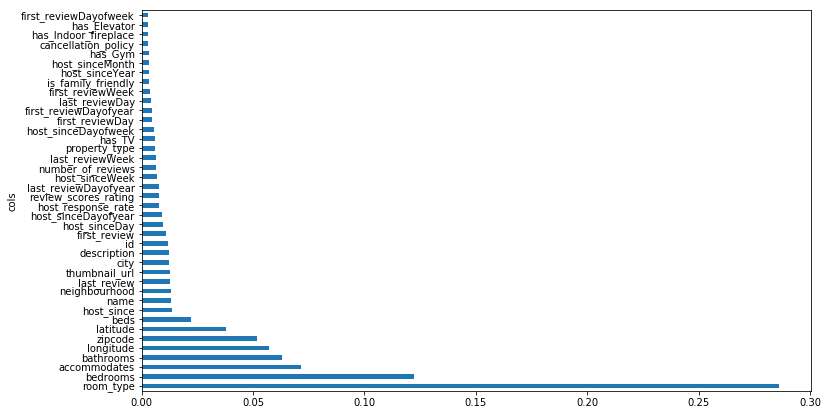

In [113]:
plot_fi(fi[:40])

The most important feature is by far the roomtype. That is followed by the number of bedrooms and persons the accomodation accomodates. The different amenities only play a minor role. One could think about clustering some of them as e.g. all which are expected to belong to premium accomodations as e.g. 'has_Indoor_fireplace', 'has_Pool', 'has_Gym' since they don't appear that often and not necessarily together. That way one could help the Regressor to use the premium amenities more often in its trees. 

Now we are going to check if the feature importance changes once we drop all the features with a very little impact on the price.

In [116]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

28

In [117]:
df_keep = df[to_keep].copy()
X_train, X_valid, X_test = split_vals(df_keep, n_trn, n_final)

X_train.shape, y_train.shape, X_valid.shape, X_test.shape

((54111, 28), (54111,), (10000, 28), (10000, 28))

In [118]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 10.7 s
[0.2167542055519452, 0.3895463212225301, 0.9085571850395296, 0.7027419922422489, 0.6922190922136766]


The r2 of the validation set improves quite a bit in comparison to the training set with 50 trees which had an r2 of ~0.68

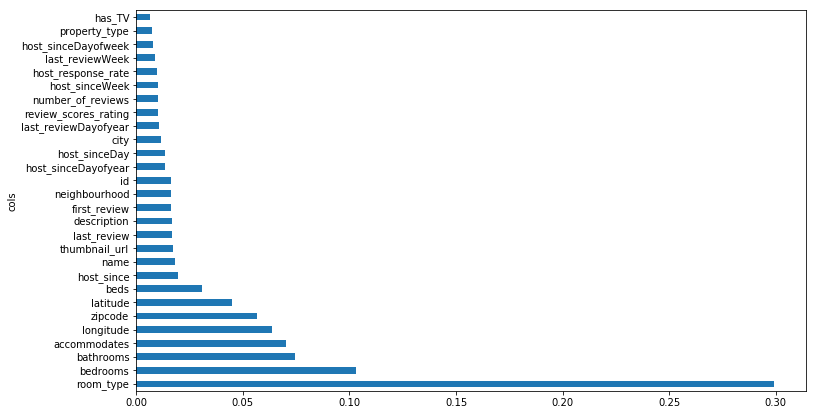

In [119]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

The new feature importance identifies some minor shifts as e.g. the slight reduction of importance of 'bedrooms' and the slight increase in importance of 'room_type' but no major movements. 'room_type' really seems to be by far the most important feature.

Let's take a closer look at these most important features

In [122]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.67 s


(5.043675198730935, 0.3713862923940245)

In [123]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])
#Produces BrokenProcessPool but functions anyways

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

(5.043675198730935, 0.3713862923940245)

### Analysis room_type

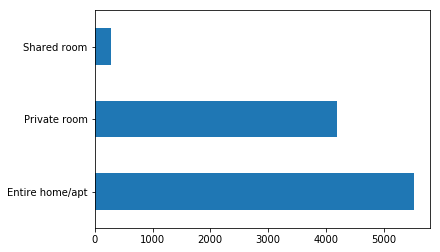

In [125]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.room_type.value_counts().plot.barh();

In [126]:
flds = ['room_type', 'log_price', 'pred', 'pred_std']
room_type_summ = x[flds].groupby('room_type', as_index=False).mean()
room_type_summ

,room_type,log_price,pred,pred_std
0,Entire home/apt,5.172175,5.176504,0.348996
1,Private room,4.340669,4.329395,0.342780
2,Shared room,3.880654,3.884164,0.442350


The impact on the price of the three different types makes sense. However, we have a high standard deviation for shared rooms since there is much less data available for this room type. A senseful analysis if Airbnb would be a client could be why that is so. Maybe it is less represented because their is much less demand for such a roomtype. Another reason could be that the hosts offer this type less frequently because it is less profitable since they have to offer it for a much lower price since they would not reach any bookings otherwise.

### Analysis bedrooms

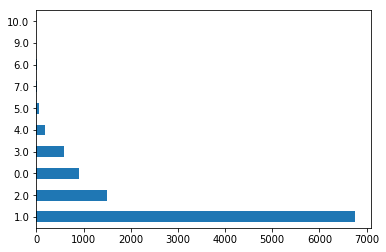

In [127]:
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.bedrooms.value_counts().plot.barh();

In [128]:
flds = ['bedrooms', 'log_price', 'pred', 'pred_std']
bedrooms_summ = x[flds].groupby('bedrooms', as_index=False).mean()
bedrooms_summ

,bedrooms,log_price,pred,pred_std
0,0.0,4.826775,4.858776,0.321197
1,1.0,4.546864,4.542011,0.337230
2,2.0,5.286792,5.283353,0.371946
3,3.0,5.655218,5.648794,0.426409
4,4.0,5.977602,5.964078,0.455577
5,5.0,6.393548,6.316275,0.458788
6,6.0,6.493621,6.488284,0.350826
7,7.0,7.094187,6.666075,0.454351
8,9.0,6.224509,6.085624,0.548809
9,10.0,6.876605,6.294851,0.560469


### Analysis accomodates

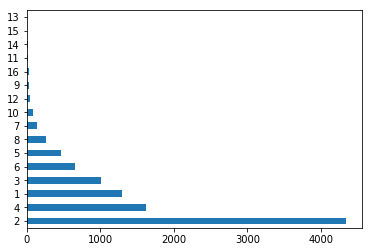

In [129]:
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.accommodates.value_counts().plot.barh();

In [130]:
flds = ['accommodates', 'log_price', 'pred', 'pred_std']
accommodates_summ = x[flds].groupby('accommodates', as_index=False).mean()
accommodates_summ

,accommodates,log_price,pred,pred_std
0,1,4.199433,4.211512,0.378671
1,2,4.553888,4.559814,0.323313
2,3,4.825439,4.826184,0.330105
3,4,5.079010,5.066059,0.351355
4,5,5.246052,5.249429,0.371818
5,6,5.467813,5.451337,0.395407
6,7,5.492089,5.474852,0.413458
7,8,5.722287,5.681004,0.413160
8,9,5.799678,5.693411,0.417509
9,10,5.941850,5.842357,0.439236


'bedrooms' and 'accomodates' show a similar analysis. The amount of data decreases while the number of 'bedrooms'/'accomodates' increases. This makes sense as demand and offer will be smaller for larger accommodations. The price also increases with the number of 'bedrooms'/'accomodations' until you reach 7 bedrooms/ 9 guests. After that the price is relatively stable as these large accomodations probably can only be booked as full accomodations with one single price for the accomodation independently of the number of bedrooms/guests. So that groups of e.g. 10 guests book the same accomodations as e.g. groups of 14 guests. Thus they pay on average similar prices. 

### Removing redundant features

In [131]:
from scipy.cluster import hierarchy as hc

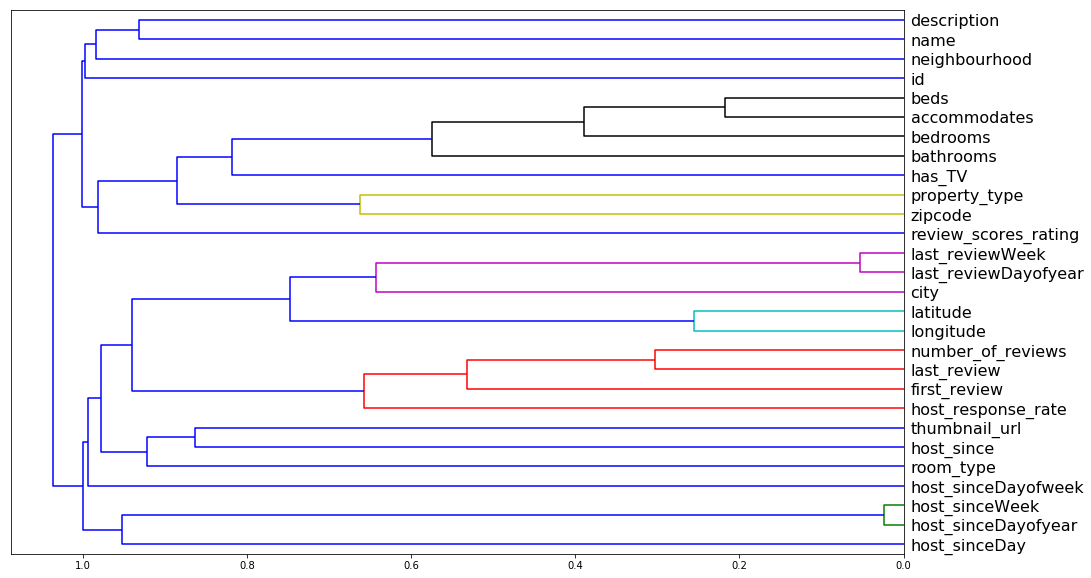

In [132]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

The dendogram identifies less correlations than ecpected. 'host_sinceWeek' and 'host_sinceDayofyear' of course don't need to be both in the data. Maybe we can even exclude both since we also have 'host_sinceDayofweek' in the data. The same is true for 'last_reviewWeek' and 'last_reviewDayofyear'. The correlation between latitude and longitude also makes sense since they together define the location. We should try to put them into one combined feature. The correlation between 'beds' and 'accomodates' makes also sense. We should try to exclude one of them. However, there is no correlation visible between 'neighbourhood', 'zipcode', 'latitude' and 'longitude' altough they all describe the location of the accomodation. We might want to check if that really is the case. 

These would be the next steps. Afterwards I would do a first check with the test set which has not been used so far.